<a href="https://colab.research.google.com/github/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/RNN_CPR_multivar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

In [12]:
url = "https://github.com/RiddhimanRaut/Deep-Learning-based-CPR-estimation/blob/main/excel_dataset.xlsx?raw=true"
df = pd.read_excel(url)
df = df[5::6] #Hour-wise Data
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day
df['Day sin' ] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos' ] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
df.head()

,CPRAVG,PROP,BUT,ETHYLENE,AI12201M,FLW,COT,TEMP,PRESS,O2,DRAFT,ETH,Day sin,Day cos,Year sin,Year cos
5,0.426381,19.491810,4.601716,30.532320,0.012364,30656.66992,819.507965,632.023209,0.467722,1.319569,-5.266271,74.667397,0.258819,0.965926,0.010049,0.999950
11,0.424473,19.367620,4.547985,30.837540,0.011713,30590.67969,821.882797,632.649200,0.469376,1.111588,-4.903431,74.886887,0.500000,0.866025,0.010766,0.999942
17,0.425650,19.237329,4.487629,30.659901,0.011062,30524.69922,822.465134,632.817825,0.466901,1.149024,-4.946926,75.145287,0.707107,0.707107,0.011483,0.999934
23,0.427131,19.201321,4.403272,30.776039,0.011140,30527.44922,824.627869,634.766495,0.471751,1.014898,-4.618164,75.280724,0.866025,0.500000,0.012199,0.999926
29,0.428690,17.998270,4.266049,31.351549,0.012562,30576.58008,825.376816,636.005157,0.470348,1.036991,-4.617743,76.774757,0.965926,0.258819,0.012916,0.999917


In [20]:
#Data Pre-processing

# Select features (columns) to be involved intro training and predictions
no_of_columns = df.shape[1]
cols = list(df)[0:no_of_columns]

dataset = df.astype(float)
dataset = np.array(dataset)
n = len(dataset)
training_set = dataset[0:int(n*0.7)]
test_set = dataset[int(n*0.7):n]

In [42]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#sc = MinMaxScaler(feature_range = (0,1))
sc = StandardScaler()
sc1 = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc1.fit_transform(training_set[:,0].reshape(-1,1))
training_set_scaled

array([[-3.49919697,  0.21070648,  0.98686927, ...,  1.36814252,
        -1.86958041,  1.15731076],
       [-3.6069198 ,  0.14277051,  0.90250047, ...,  1.22692777,
        -1.8667508 ,  1.15726172],
       [-3.54047646,  0.07149674,  0.80772876, ...,  1.00228755,
        -1.8639212 ,  1.1572093 ],
       ...,
       [ 1.00062857, -0.66993307, -0.70436764, ..., -1.41080189,
         1.51542448, -2.14583671],
       [ 1.02237928, -0.66987777, -0.72798195, ..., -1.36263617,
         1.51683137, -2.14992512],
       [ 1.01769998, -0.66992159, -0.24543809, ..., -1.22142142,
         1.51823649, -2.15401521]])

In [43]:
X_train = []
y_train = []
training_length = len(training_set_scaled)
for i in range(60, training_length):
    X_train.append(training_set_scaled[i-60:i,1:no_of_columns])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(1394, 60, 15)

In [44]:
# Part 2 - Building the RNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [54]:
regressor = Sequential()
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

# Adding the output layer
regressor.add(Dense(units = 1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
44/44 [==============================] - 11s 107ms/step - loss: 0.2423
Epoch 2/100
44/44 [==============================] - 5s 108ms/step - loss: 0.0345
Epoch 3/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0259
Epoch 4/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0218
Epoch 5/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0202
Epoch 6/100
44/44 [==============================] - 5s 108ms/step - loss: 0.0214
Epoch 7/100
44/44 [==============================] - 5s 110ms/step - loss: 0.0203
Epoch 8/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0199
Epoch 9/100
44/44 [==============================] - 5s 110ms/step - loss: 0.0178
Epoch 10/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0166
Epoch 11/100
44/44 [==============================] - 5s 109ms/step - loss: 0.0129
Epoch 12/100
44/44 [==============================] - 5s 108ms/step - loss: 0.0170
Epoch 13/100

In [55]:
test_set_scaled = sc.transform(test_set)
test_length = len(test_set_scaled)
X_test = []
for i in range(60, test_length):
    X_test.append(test_set_scaled[i-60:i, 1:no_of_columns])
X_test = np.array(X_test)
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape


(564, 60, 15)

In [56]:
predicted_CPRAVG = regressor.predict(X_test)
predicted_CPRAVG.shape
predicted_CPRAVG = sc1.inverse_transform(predicted_CPRAVG)



In [57]:
predicted_CPRAVG

array([[0.50861365],
       [0.50854754],
       [0.5084525 ],
       [0.5083328 ],
       [0.508191  ],
       [0.5080462 ],
       [0.5079185 ],
       [0.50782245],
       [0.5077674 ],
       [0.50775504],
       [0.5077786 ],
       [0.5078315 ],
       [0.5079056 ],
       [0.50798994],
       [0.5080794 ],
       [0.5081721 ],
       [0.5082658 ],
       [0.5083594 ],
       [0.5084451 ],
       [0.50851905],
       [0.5085704 ],
       [0.508597  ],
       [0.50860244],
       [0.50858814],
       [0.5085468 ],
       [0.5084792 ],
       [0.5083766 ],
       [0.508255  ],
       [0.5081329 ],
       [0.5080256 ],
       [0.50792813],
       [0.50784   ],
       [0.5077584 ],
       [0.5076311 ],
       [0.50751096],
       [0.507489  ],
       [0.5075466 ],
       [0.5076236 ],
       [0.50772953],
       [0.50785536],
       [0.5079929 ],
       [0.50812256],
       [0.5082514 ],
       [0.50835407],
       [0.50842905],
       [0.5084864 ],
       [0.5085203 ],
       [0.508

In [58]:
real_CPRAVG_plot = df['CPRAVG']
predicted_CPRAVG_plot = np.empty_like(real_CPRAVG_plot)
predicted_CPRAVG_plot = predicted_CPRAVG_plot.reshape(-1,1)
predicted_CPRAVG_plot[:,:] = np.nan
predicted_CPRAVG_plot[training_length+60:training_length+test_length,:] = predicted_CPRAVG


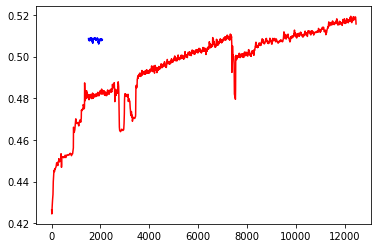

In [59]:
plt.plot(real_CPRAVG_plot, color = 'red', label = "Real CPRAVG")
plt.plot(predicted_CPRAVG_plot, color = 'blue', label = 'Predicted CPRAVG')